In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from cbrain.imports import *
from cbrain.utils import *
from matplotlib.animation import FuncAnimation
from IPython.display import SVG, HTML, FileLink

/export/home/srasp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [158]:
FIG_DIR = './figures/'

In [204]:
DATA_DIR = '/beegfs/DATA/pritchard/srasp/'
%ls {DATA_DIR}

nnatmonly_fbp8_D002_andkua/         nonsp_4k/
nnatmonly_fbp8_D003_andkua/         nonsp_andkua/
nnatmonly_fbp8_D004_3kw1_allfix/    old_3kw1/
nnatmonly_fbp8_D004_4k_allfix/      old_data/
nnatmonly_fbp8_D004_andkua_allfix/  preprocessed_data/
nnatmonly_fbp8_D004_andkua_msefix/  sp32fbp_andkua/
nnatmonly_fbp8_D004_andkua_nofix/   sp8fbp_3kw1/
nnatmonly_fbp8_D004_andkua_qfix/    sp8fbp_4k/
nnatmonly_fbp8_D005_andkua_nofix/   sp8fbp_andkua/
nnfullphy_fbp32_E002_andkua/        sp8fbp_andkua_nobeta/
nnfullphy_fbp8_E001_andkua/         tmp/
nnfullphy_std8_A003/                wkspectra/
nonsp_3kw1/


In [371]:
exps_ak = ['sp8fbp_andkua', 'nnatmonly_fbp8_D004_andkua_allfix', 'nonsp_andkua']
exps_3kw1 = ['sp8fbp_3kw1', 'nnatmonly_fbp8_D004_3kw1_allfix', 'nonsp_3kw1']
exps_4k = ['sp8fbp_4k', 'nnatmonly_fbp8_D004_4k_allfix', 'nonsp_4k']
exps = exps_ak + exps_3kw1 + exps_4k

In [372]:
%%time
h0s = {e : xr.open_mfdataset(f'{DATA_DIR}{e}/*.h0.0000-*', decode_times=False) for e in exps}
h1s = {e : xr.open_mfdataset(f'{DATA_DIR}{e}/*.h1.0000-*', decode_times=False) for e in exps}

CPU times: user 1min 3s, sys: 1.28 s, total: 1min 4s
Wall time: 11min


In [373]:
h0s['sp8fbp_andkua_nobeta'] = xr.open_mfdataset(f'{DATA_DIR}sp8fbp_andkua_nobeta/*.h0.0000-*', decode_times=False)

In [374]:
with open('./saved_ds.pkl', 'wb') as f:
    pickle.dump((h0s, h1s), f)

In [375]:
with open('./saved_ds.pkl', 'rb') as f:
    h0s, h1s = pickle.load(f)

In [377]:
def compare(func, exps, ref=None, title=None, hs=h0s, **kwargs):
    npanels = len(exps) if ref is None else len(exps) + 1
    ncols=min(3, npanels); nrows=int(np.ceil(npanels/ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(13.5, 4*nrows));
    if ref is None:
        [func(hs[e]).plot(ax=ax, **kwargs) for e, ax in zip(exps, axs.flat)]
        [ax.set_title(e) for e, ax in zip(exps, axs.flat)]
    else:
        yi = kwargs['yincrease'] if 'yincrease' in kwargs.keys() else None
        func(hs[ref]).plot(ax=axs.flat[0], yincrease=yi); axs.flat[0].set_title(ref)
        [(func(hs[e])-func(hs[ref]).values).plot(ax=ax, **kwargs) for e, ax in zip(exps, axs.flat[1:])]
        [ax.set_title(f'{e} - {ref}') for e, ax in zip(exps, axs.flat[1:])]
    if title is None: plt.tight_layout()
    else: fig.suptitle(title); plt.tight_layout(rect=(0, 0, 1, 0.95))
    return fig, axs

In [378]:
def compare_line(func, exps, ax=None, legend=True, hs=h0s, **kwargs):
    if ax is None: fig, ax = plt.subplots(figsize=(6, 5))
    [func(hs[e]).plot(ax=ax, label=e, **kwargs) for e in exps]
    if legend: ax.legend()

In [210]:
inchincm = 2.45
pagewidth = 18.3/inchincm # Inches
pagewidth

7.469387755102041

In [211]:
FONTSIZE = 7
plt.rc('font', size=FONTSIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONTSIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONTSIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONTSIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONTSIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONTSIZE)    # legend fontsize
plt.rc('figure', titlesize=FONTSIZE)  # fontsize of the figure title

## Mean climate and parameterized tendencies

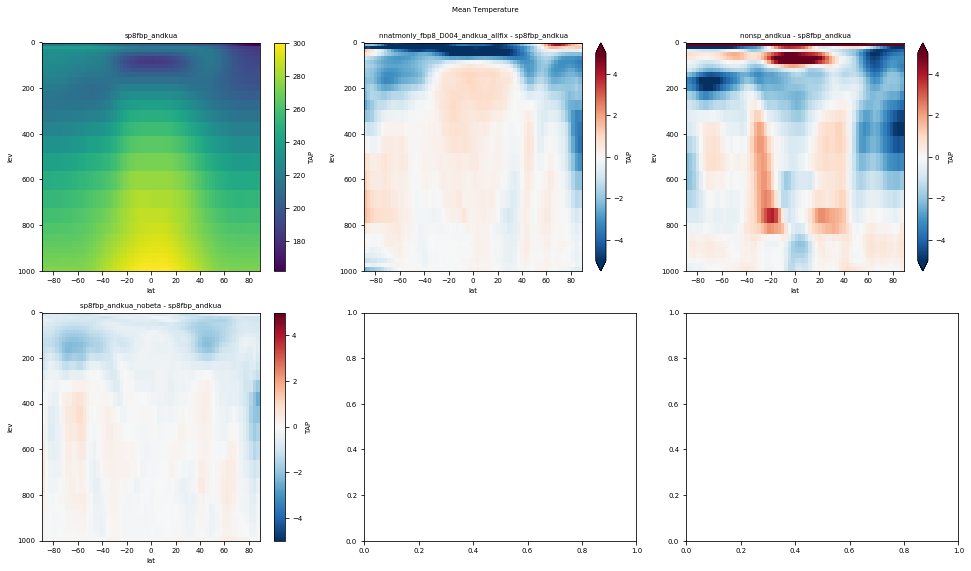

In [266]:
compare(lambda d: d['TAP'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_ak[1:] + ['sp8fbp_andkua_nobeta'], ref=exps_ak[0], 
        yincrease=False, vmin=-5, vmax=5, cmap='RdBu_r', title='Mean Temperature');

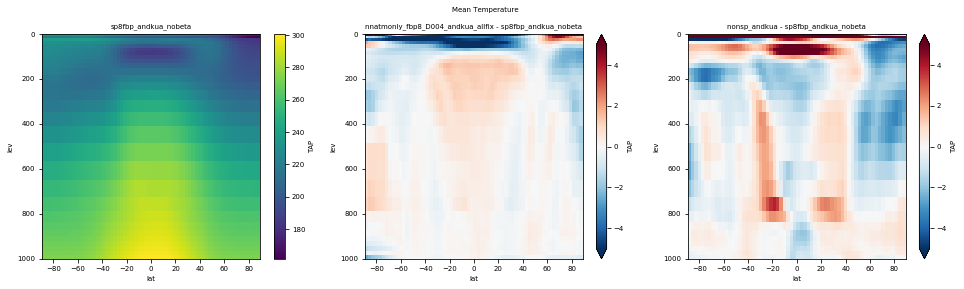

In [267]:
compare(lambda d: d['TAP'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_ak[1:], ref='sp8fbp_andkua_nobeta', 
        yincrease=False, vmin=-5, vmax=5, cmap='RdBu_r', title='Mean Temperature');

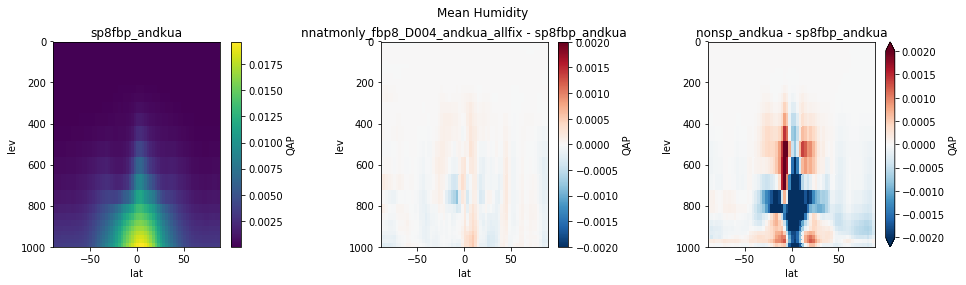

In [17]:
compare(lambda d: d['QAP'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_ak[1:], ref=exps_ak[0], 
        yincrease=False, vmin=-0.002, vmax=0.002, cmap='RdBu_r', title='Mean Humidity');

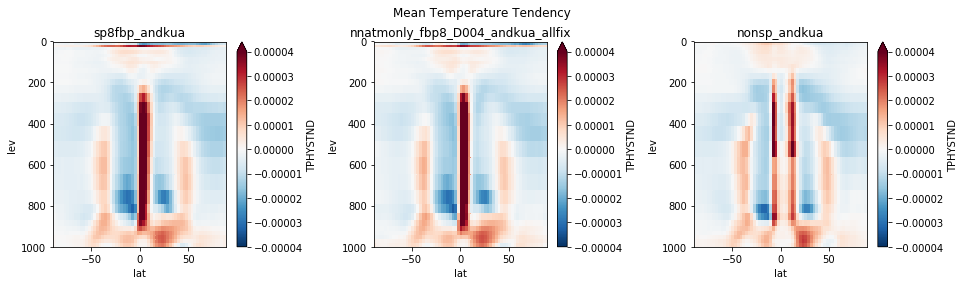

In [15]:
compare(lambda d: d['TPHYSTND'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_ak, 
        yincrease=False, vmin=-4e-5, vmax=4e-5, cmap='RdBu_r', title='Mean Temperature Tendency');

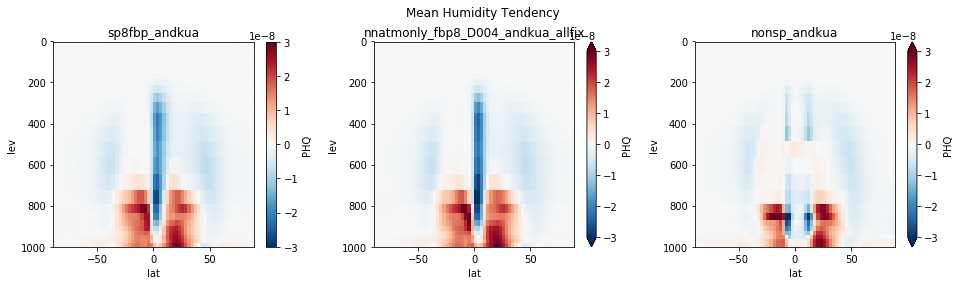

In [18]:
compare(lambda d: d['PHQ'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_ak, 
        yincrease=False, vmin=-3e-8, vmax=3e-8, cmap='RdBu_r', title='Mean Humidity Tendency');

### Final plot for paper

In [276]:
mean_t = [h0s[e]['TAP'].sel(time=slice(30, None)).isel(lev=slice(3,None)).mean(('time', 'lon')).compute() 
          for e in exps_ak]
mean_q = [h0s[e]['QAP'].sel(time=slice(30, None)).isel(lev=slice(3,None)).mean(('time', 'lon')).compute() 
          for e in exps_ak]

In [278]:
# Gaussian latitudes
lats = h0s[exps_ak[0]].lat.values
gw = h0s[exps_ak[0]].gw.isel(time=0)
gwsum = np.cumsum(gw.values)
for t, q in zip(mean_t, mean_q): t['lat'] = gwsum; q['lat'] = gwsum

In [217]:
label_lats = [-60, -30, 0, 30, 60]
gw_lats = [np.interp(l, lats, gwsum) for l in label_lats]

In [304]:
def mean_tq_panels(data, vmin=-5, vmax=5, cm1='plasma', cm2='RdBu_r', unit='Temperature [K]', 
                   contourf=False, levels1=None, levels2=None):
    fig, axs = plt.subplots(1, 3, figsize=(pagewidth, 3))
    if contourf:
        data[0].plot.contourf(ax=axs[0], yincrease=False, add_colorbar=False, cmap=cm1, levels=levels1)
    else:
        data[0].plot(ax=axs[0], yincrease=False, add_colorbar=False, cmap=cm1)
    for ax, d in zip(axs.flat[1:], data[1:]):
        if contourf:
            im = (d - data[0]).plot.contourf(ax=ax, yincrease=False, add_colorbar=False,cmap=cm2, levels=levels2)
        else:
            im = (d - data[0]).plot(ax=ax, yincrease=False, add_colorbar=False, vmin=vmin, vmax=vmax, cmap=cm2)
        
    [ax.set_xticks(gw_lats) for ax in axs.flat]; [ax.set_xticklabels(label_lats) for ax in axs.flat]; 
    [ax.set_yticks([]) for ax in axs.flat[1:]]; [ax.set_ylabel('') for ax in axs.flat[1:]];
    axs[0].set_ylabel('Pressure [hPa]'); [ax.set_xlabel('Latitude') for ax in axs.flat]
    
    plt.subplots_adjust(wspace=0.03, left=0.1, right=1.0)
    cb = fig.colorbar(im, ax=axs.flat, pad=0.01, extend='both', use_gridspec=False); cb.set_label(unit)
    
    axs[0].set_title('SPCAM Temperature'); axs[1].set_title('NNCAM - SPCAM'); axs[2].set_title('CTRLCAM - SPCAM');
    return fig

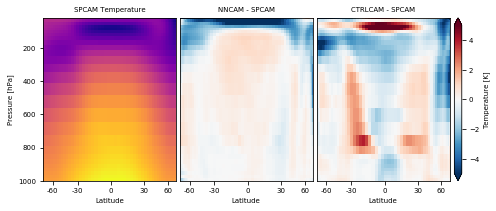

In [305]:
mean_tq_panels(mean_t);

In [310]:
np.arange(-5, 5.5, 0.5).shape

(21,)

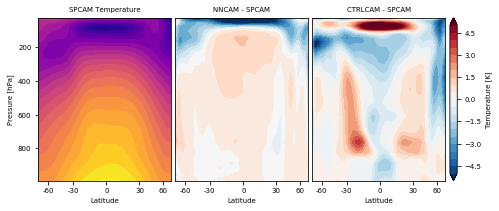

In [319]:
f = mean_tq_panels(mean_t, contourf=True, levels1=np.linspace(185, 300, 20), levels2=np.arange(-5, 5.5, 0.5));

In [320]:
f.savefig(f'{FIG_DIR}mean_temperature.pdf')

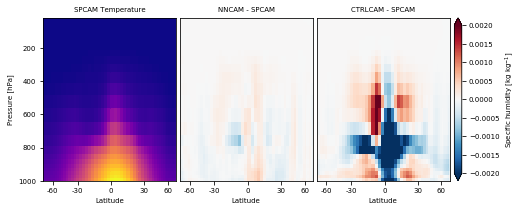

In [309]:
mean_tq_panels(mean_q, vmin=-0.002, vmax=0.002, unit=r'Specific humidity [kg kg$^{-1}$]');

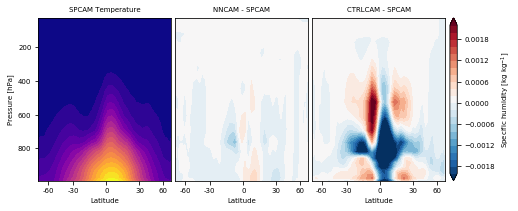

In [317]:
f = mean_tq_panels(mean_q, contourf=True, levels1=np.linspace(0, 0.02, 20), levels2=np.arange(-0.002, 0.0022, 0.0002),
              unit=r'Specific humidity [kg kg$^{-1}$]');

In [318]:
f.savefig(f'{FIG_DIR}mean_humidity.pdf')

In [327]:
def mean_tqphy_panels(data, unit='$\Delta$T$_{phys}$ [K s$^{-1}$]', contourf=False, **kwargs):
    fig, axs = plt.subplots(1, 3, figsize=(pagewidth, 3))
    for i, (ax, d) in enumerate(zip(axs.flat, data)):
        if contourf:
            im = d.plot.contourf(ax=ax, yincrease=False, add_colorbar=False, **kwargs)
        else:
            im = d.plot(ax=ax, yincrease=False, add_colorbar=False, **kwargs)
        
    [ax.set_xticks(gw_lats) for ax in axs.flat]; [ax.set_xticklabels(label_lats) for ax in axs.flat]; 
    [ax.set_yticks([]) for ax in axs.flat[1:]]; [ax.set_ylabel('') for ax in axs.flat[1:]];
    axs[0].set_ylabel('Pressure [hPa]'); [ax.set_xlabel('Latitude') for ax in axs.flat]
    
    plt.subplots_adjust(wspace=0.03, left=0.1, right=1.0)
    cb = fig.colorbar(im, ax=axs.flat, pad=0.01, extend='both', use_gridspec=False); cb.set_label(unit)
    cb.formatter.set_powerlimits((0, 0)); cb.update_ticks()
    cb.ax.yaxis.set_offset_position('left')
    
    axs[0].set_title('SPCAM'); axs[1].set_title('NNCAM'); axs[2].set_title('CTRLCAM');
    return fig

In [321]:
tphys = [h0s[e]['TPHYSTND'].sel(time=slice(30, None)).isel(lev=slice(3,None)).mean(('time', 'lon')).compute() 
         for e in exps_ak]
phqs = [h0s[e]['PHQ'].sel(time=slice(30, None)).isel(lev=slice(3,None)).mean(('time', 'lon')).compute() 
         for e in exps_ak]

In [322]:
for t, q in zip(tphys, phqs): t['lat'] = gwsum; q['lat'] = gwsum

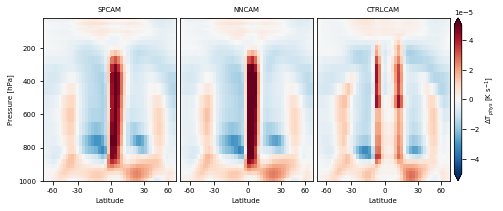

In [328]:
f = mean_tqphy_panels(tphys, vmin=-5e-5, vmax=5e-5, cmap='RdBu_r')

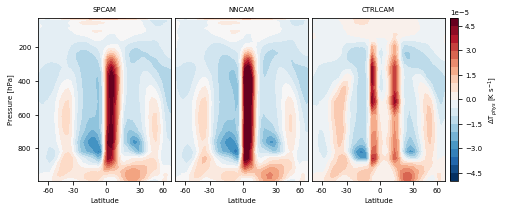

In [329]:
f = mean_tqphy_panels(tphys, contourf=True, cmap='RdBu_r', levels=np.arange(-5e-5, 5.5e-5, 5e-6))

In [330]:
f.savefig(f'{FIG_DIR}mean_tphys.pdf')

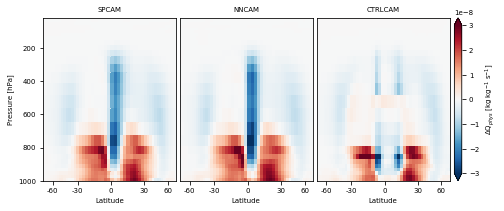

In [335]:
f = mean_tqphy_panels(phqs, vmin=-3e-8, vmax=3e-8, cmap='RdBu_r', unit='$\Delta$Q$_{phys}$ [kg kg$^{-1}$ s$^{-1}$]')

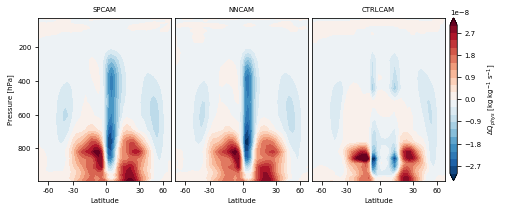

In [336]:
f = mean_tqphy_panels(phqs, contourf=True, cmap='RdBu_r', levels=np.arange(-3e-8, 3.3e-8, 3e-9),
                      unit='$\Delta$Q$_{phys}$ [kg kg$^{-1}$ s$^{-1}$]')

In [337]:
f.savefig(f'{FIG_DIR}mean_phq.pdf')

## Variability

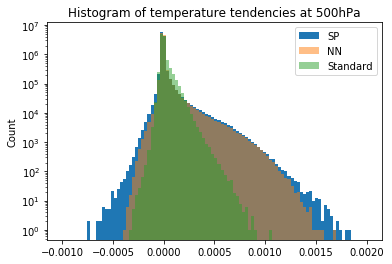

In [44]:
[h1s[e]['TPHYSTND'].sel(time=slice(30, None)).sel(lev=500, method='nearest').plot(
    range=(-1e-3, 2e-3), bins=100, label=e, alpha=1. if i==0 else 0.5) 
 for i, e in enumerate(exps_ak)];
plt.legend(['SP', 'NN', 'Standard']); plt.yscale('log')
plt.title('Histogram of temperature tendencies at 500hPa');

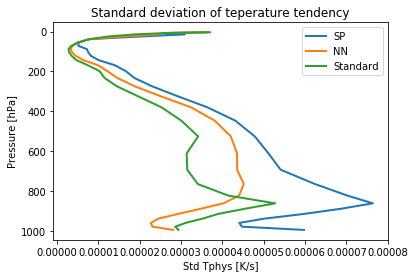

In [19]:
[plt.plot(h1s[e]['TPHYSTND'].sel(time=slice(30, None)).std(('time', 'lon')).mean('lat'), h1s[e].lev, label=e, lw=2)
 for i, e in enumerate(exps_ak)];
plt.legend(['SP', 'NN', 'Standard']); plt.gca().invert_yaxis()
plt.title('Standard deviation of teperature tendency'); plt.ylabel('Pressure [hPa]'); plt.xlabel('Std Tphys [K/s]');

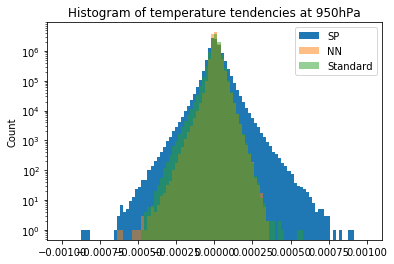

In [45]:
[h1s[e]['TPHYSTND'].sel(time=slice(30, None)).sel(lev=950, method='nearest').plot(
    range=(-1e-3, 1e-3), bins=100, label=e, alpha=1. if i==0 else 0.5) 
 for i, e in enumerate(exps_ak)];
plt.legend(['SP', 'NN', 'Standard']); plt.yscale('log')
plt.title('Histogram of temperature tendencies at 950hPa');

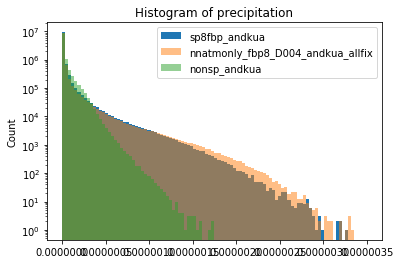

In [41]:
[h1s[e]['PRECT'].sel(time=slice(30, None)).plot(
    range=(0, 3.5e-6), bins=100, label=e, alpha=1. if i==0 else 0.5) 
 for i, e in enumerate(exps_ak)];
plt.legend(); plt.yscale('log')
plt.title('Histogram of precipitation');

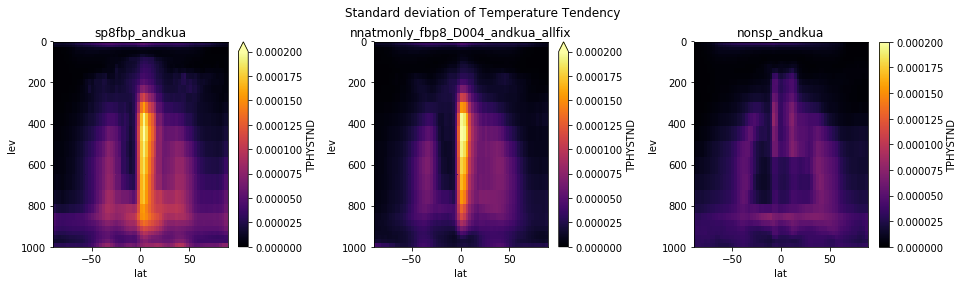

In [57]:
compare(lambda d: d['TPHYSTND'].sel(time=slice(30, 90)).std(('time', 'lon')), exps_ak, hs=h1s,
        yincrease=False, vmin=0, vmax=2e-4, cmap='inferno', title='Standard deviation of Temperature Tendency');

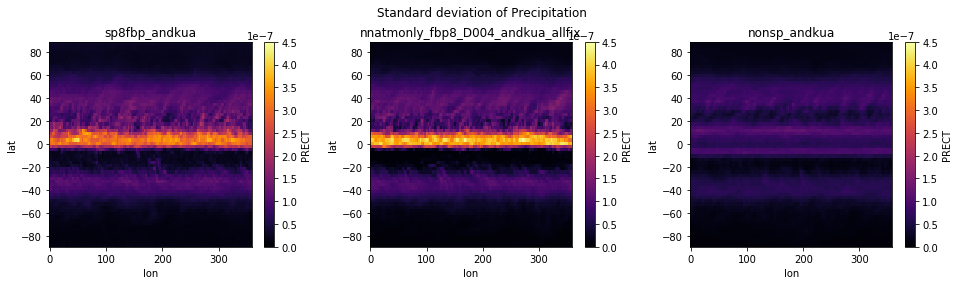

In [54]:
compare(lambda d: d['PRECT'].sel(time=slice(30, None)).std(('time')), exps_ak, hs=h1s,
        vmin=0, vmax=4.5e-7, cmap='inferno', title='Standard deviation of Precipitation');

### Plot for paper

In [359]:
stds = [h1s[e]['TPHYSTND'].sel(time=slice(30, None, 12)).isel(lev=slice(3, None)).std(('time', 'lon')).mean('lat').compute()
        for i, e in enumerate(exps_ak)];

In [361]:
levs = h1s[exps_ak[0]].lev[3:].values

In [362]:
colors = ['dodgerblue', 'firebrick', 'darkgreen']

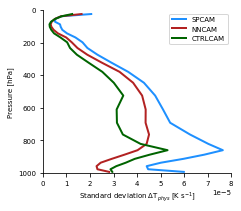

In [363]:
fig, ax = plt.subplots(figsize=(pagewidth/2, 3))
plt.subplots_adjust(left=0.2, right=0.9)
[plt.plot(stds[i], levs, label=e, c=colors[i], lw=2) for i, e in enumerate(['SPCAM', 'NNCAM', 'CTRLCAM'])]
ax.legend()
sns.despine()
ax.set_xlabel(r'Standard deviation $\Delta$T$_{phys}$ [K s$^{-1}$]'); ax.set_ylabel(r'Pressure [hPa]')
#ax.set_title('Heating rate variability')
ax.ticklabel_format(axis='x', scilimits=(0, 0))
ax.set_ylim(0, 1000); ax.set_xlim(0, 0.8e-4)
ax.invert_yaxis()

In [364]:
fig.savefig(f'{FIG_DIR}std_tphys.pdf')

In [360]:
prects = [h1s[e]['PRECT'].sel(time=slice(30, None)).plot(range=(0, 3.5e-6), bins=100, label=e) 
          for i, e in enumerate(exps_ak)];
plt.close('all')

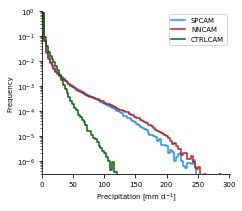

In [367]:
fig, ax = plt.subplots(figsize=(pagewidth/2, 3))
plt.subplots_adjust(left=0.2, right=0.9)
[ax.step(prects[i][1][:-1]*1e3*24*3600, prects[i][0]/prects[i][0].sum(), label=e, c=colors[i], where='post') 
 for i, e in enumerate(['SPCAM', 'NNCAM', 'CTRLCAM'])]
ax.set_yscale('log')
ax.legend()
sns.despine()
ax.set_xlabel(r'Precipitation [mm d$^{-1}$]'); ax.set_ylabel(r'Frequency')
#ax.set_title('Precipitation distribution')
#ax.ticklabel_format(axis='x', scilimits=(0, 0))
ax.set_ylim(3e-7, 1); 
ax.set_xlim(0, prects[0][1][-1]*1e3*24*3600);

In [368]:
fig.savefig(f'{FIG_DIR}prec_hist.pdf')

## Generalization to new SSTs

In [382]:
for d in h0s.values(): 
    d['vTAP'] = vint(d, 'TAP', C_P); d['vQAP'] = vint(d, 'QAP', L_V)
    d['vTPHY'] = vint(d, 'TPHYSTND', C_P); d['vPHQ'] = vint(d, 'PHQ', L_V)

### 3KW1

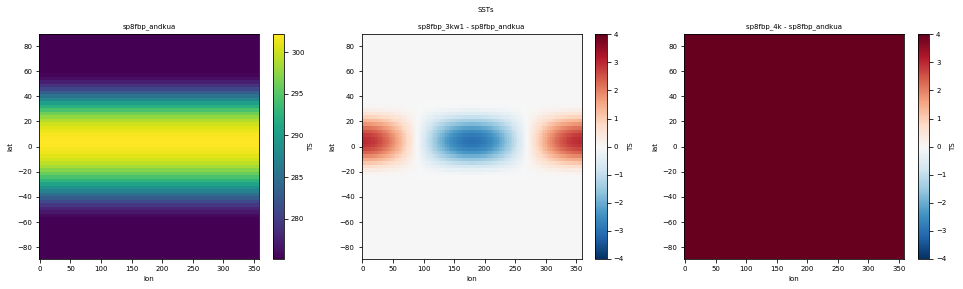

In [380]:
compare(lambda d: d['TS'].isel(time=0), [exps_3kw1[0], exps_4k[0]], ref=exps_ak[0],
        title='SSTs', vmin=-4, vmax=4, cmap='RdBu_r');

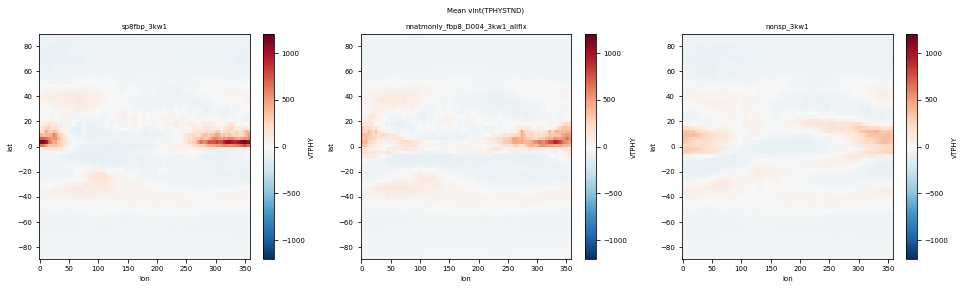

In [383]:
compare(lambda d: d['vTPHY'].sel(time=slice(30, None)).mean(('time')), exps_3kw1,
        vmin=-1200, vmax=1200, cmap='RdBu_r', title='Mean vint(TPHYSTND)');

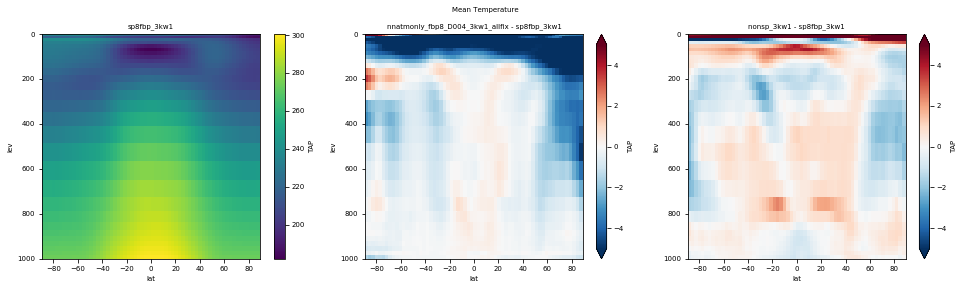

In [386]:
compare(lambda d: d['TAP'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_3kw1[1:], ref=exps_3kw1[0], 
        yincrease=False, vmin=-5, vmax=5, cmap='RdBu_r', title='Mean Temperature');

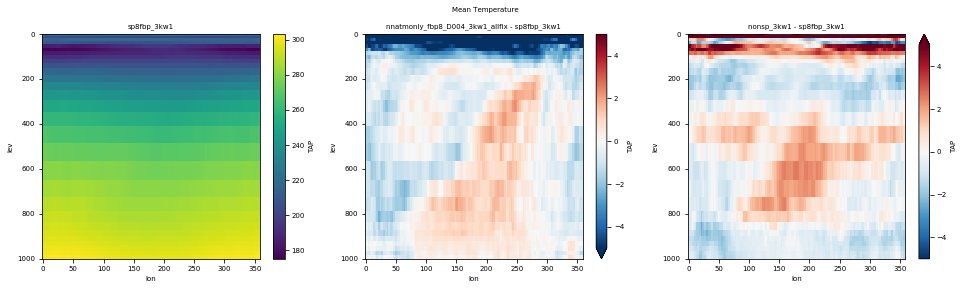

In [388]:
compare(lambda d: d['TAP'].sel(time=slice(30, None)).sel(lat=0, method='nearest').mean(('time')), exps_3kw1[1:], ref=exps_3kw1[0], 
        yincrease=False, vmin=-5, vmax=5, cmap='RdBu_r', title='Mean Temperature');

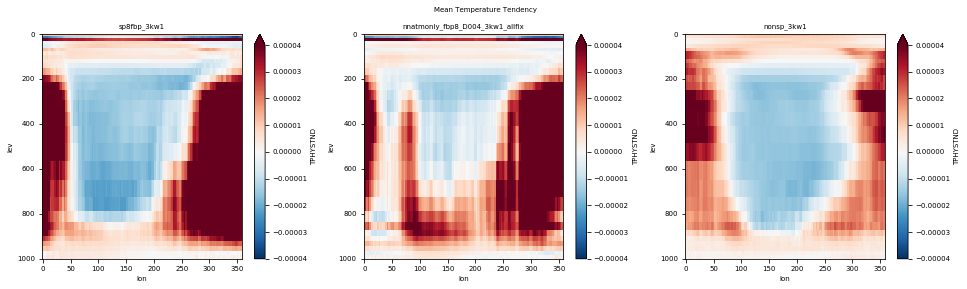

In [390]:
compare(lambda d: d['TPHYSTND'].sel(time=slice(30, None)).sel(lat=0, method='nearest').mean(('time')), exps_3kw1, 
        yincrease=False, vmin=-4e-5, vmax=4e-5, cmap='RdBu_r', title='Mean Temperature Tendency');

### +4K

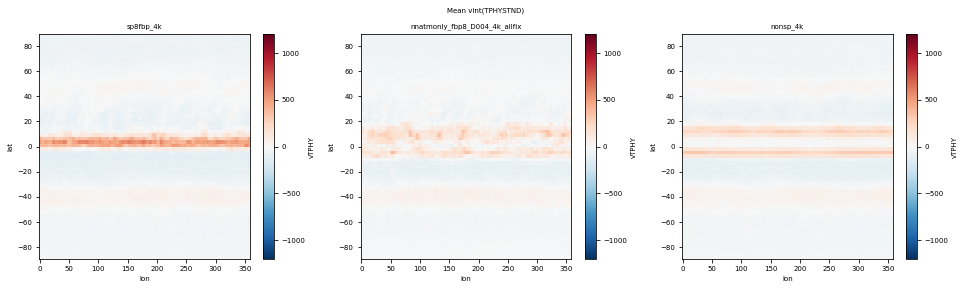

In [384]:
compare(lambda d: d['vTPHY'].sel(time=slice(30, None)).mean(('time')), exps_4k,
        vmin=-1200, vmax=1200, cmap='RdBu_r', title='Mean vint(TPHYSTND)');

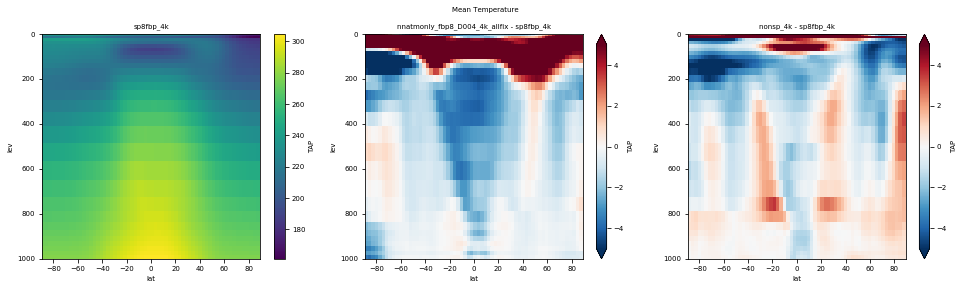

In [385]:
compare(lambda d: d['TAP'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_4k[1:], ref=exps_4k[0], 
        yincrease=False, vmin=-5, vmax=5, cmap='RdBu_r', title='Mean Temperature');

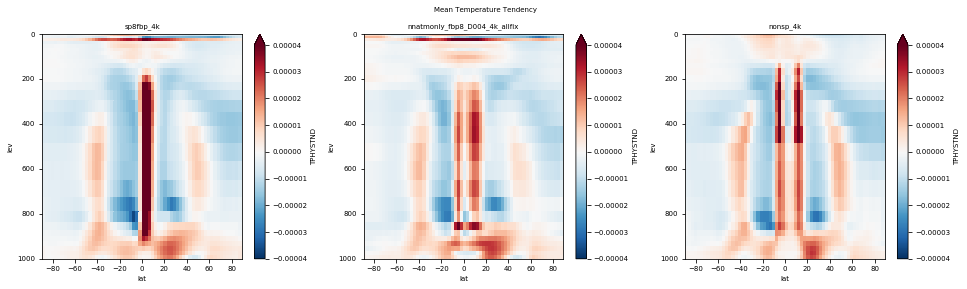

In [389]:
compare(lambda d: d['TPHYSTND'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_4k, 
        yincrease=False, vmin=-4e-5, vmax=4e-5, cmap='RdBu_r', title='Mean Temperature Tendency');

## Energy conservation

In [73]:
d = h1s['nnatmonly_fbp8_D004_andkua_allfix']

In [79]:
NNQatm = vint(d, 'NNDQ', 1)
PPQatm = vint(d, 'PPDQ', 1)

In [80]:
NNQsurf = d['NNLHF'] / L_V - d['NNPRECT'] * 1e3
PPQsurf = d['NNLHF'] / L_V - d['PPPRECT'] * 1e3

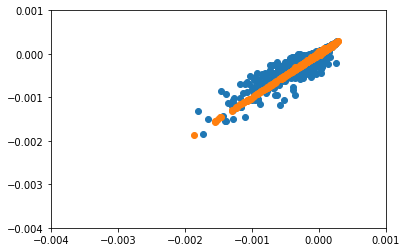

In [81]:
plt.scatter(NNQatm.isel(time=100).values.flat, NNQsurf.isel(time=100).values.flat)
plt.scatter(PPQatm.isel(time=100).values.flat, PPQsurf.isel(time=100).values.flat)
plt.xlim(-4e-3, 1e-3); plt.ylim(-4e-3, 1e-3);

In [85]:
NNSE = vint(d, 'NNDT', C_P) - d['NNSHF'] - d['NNFSNT'] + d['NNFSNS'] + d['NNFLNT'] - d['NNFLNS']
PPSE = vint(d, 'PPDT', C_P) - d['NNSHF'] - d['PPFSNT'] + d['PPFSNS'] + d['PPFLNT'] - d['PPFLNS']

In [86]:
NNME = d['NNLHF'] - vint(d, 'NNDQ', L_V)
PPME = d['NNLHF'] - vint(d, 'PPDQ', L_V)

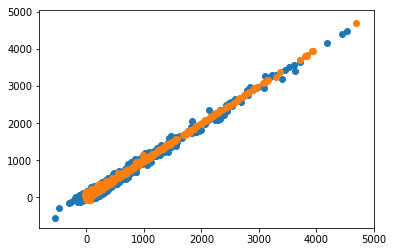

In [87]:
plt.scatter(NNSE.isel(time=100).values.flat, NNME.isel(time=100).values.flat)
plt.scatter(PPSE.isel(time=100).values.flat, PPME.isel(time=100).values.flat)

In [88]:
d_long = xr.open_mfdataset(f'{DATA_DIR}nnatmonly_fbp8_D004_andkua_allfix/*.h0.000*-*', decode_times=False)

In [90]:
h0s['nnatmonly_fbp8_D004_andkua_allfix_long'] = d_long

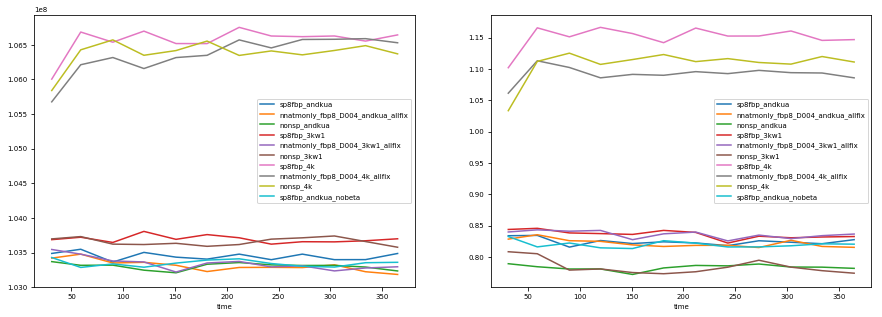

In [391]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
compare_line(lambda d: gw_avg(d, 'TE'), exps + ['sp8fbp_andkua_nobeta'], ax=axs[0])
compare_line(lambda d: gw_avg(d, 'TW'), exps + ['sp8fbp_andkua_nobeta'], ax=axs[1])

## W-K diagram

In [393]:
WK_DATA = '/beegfs/DATA/pritchard/srasp/wkdata/'
!ls {WK_DATA}

scratch
SpaceTime.PRECT.nnatmonly_fbp8_D004_3kw1_allfix.nc
SpaceTime.PRECT.nnatmonly_fbp8_D004_4k_allfix.nc
SpaceTime.PRECT.nnatmonly_fbp8_D004_andkua_allfix.nc
SpaceTime.PRECT.nonsp_3kw1.nc
SpaceTime.PRECT.nonsp_4k.nc
SpaceTime.PRECT.nonsp_andkua.nc
SpaceTime.PRECT.sp8fbp_3kw1.nc
SpaceTime.PRECT.sp8fbp_4k.nc
SpaceTime.PRECT.sp8fbp_andkua.nc


In [394]:
exps

['sp8fbp_andkua',
 'nnatmonly_fbp8_D004_andkua_allfix',
 'nonsp_andkua',
 'sp8fbp_3kw1',
 'nnatmonly_fbp8_D004_3kw1_allfix',
 'nonsp_3kw1',
 'sp8fbp_4k',
 'nnatmonly_fbp8_D004_4k_allfix',
 'nonsp_4k']

In [395]:
wks = [xr.open_dataset(f'{WK_DATA}SpaceTime.PRECT.{e}.nc') for e in exps]

In [396]:
wks = [wk.isel(freq=slice(1, None)) for wk in wks]

In [397]:
freq_days = 1/wks[0].freq

In [398]:
labels_days = [30, 6, 3, 2]
labels_freq = 1/np.array(labels_days)

In [399]:
hs = [12, 25, 50]
g = 9.81

In [400]:
def ER(k, h):
    n = 1; lat = 0.
    Beta = 2. * 7.292E-5 * np.cos(abs(lat)) / 6.37E6
    t4 = (Beta / np.ma.sqrt(g * h)) * (2 * n + 1.)
    return -Beta * k / (k * k + t4)

In [401]:
lat = 0.
ll = 2. * np.pi * 6.37E6 * np.cos(abs(lat))

In [402]:
k = 2 * np.pi * wk.wave / ll

In [403]:
def tofreq(x): return 1/(2 * np.pi / (x * 24 * 60 * 60))

In [405]:
def wk_panel(ax, data, title, add_text=True, **kwargs):
    im = ax.contourf(data.wave, data.freq, data['FIG_3_SYM'], **kwargs)
    ax.set_yticks(labels_freq); ax.set_yticklabels(labels_days);
    ax.grid(axis='y', linestyle='--', c='gray')
    [ax.plot(wk.wave, tofreq(k*np.sqrt(g * h)), c='gray', lw=0.7) for h in hs];
    [ax.plot(wk.wave, tofreq(ER(k, h)), c='gray', lw=0.7) for h in hs];
    ax.set_xlim(wk.wave[0], wk.wave[-1]); ax.set_ylim(wk.freq[0], wk.freq[-1]);
    if add_text:
        ax.text(8, 1/2.4, 'Kelvin', color='white', weight='bold', fontsize=8);
        ax.text(-14, 1/15, 'n=1 ER', color='white', weight='bold', fontsize=8);
        ax.text(6, 1/25, 'MJO', color='white', weight='bold', fontsize=8);
    ax.set_xlabel('Zonal wave number'); ax.set_ylabel('Period [days]')
    ax.set_title(title, fontsize=10)
    return im

In [406]:
titles = ['SPCAM', 'NNCAM', 'CTRLCAM']

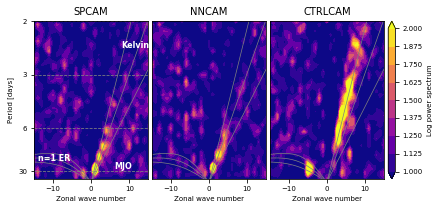

In [409]:
fig, axs = plt.subplots(1, 3, figsize=(pagewidth, 3))
for i, (ax, wk) in enumerate(zip(axs.flat, wks[:3])):
    im = wk_panel(ax, wk, titles[i], True if i == 0 else False, cmap='plasma', 
                  levels=np.linspace(1, 2, 9), extend='both')
    if i > 0: ax.set_ylabel(''); ax.set_yticks([])
plt.subplots_adjust(wspace=0.03, bottom=0.15)
cb = fig.colorbar(im, ax=axs, pad=0.01); cb.set_label('Log power spectrum')

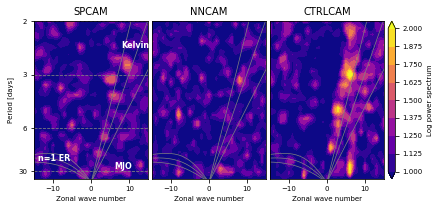

In [411]:
fig, axs = plt.subplots(1, 3, figsize=(pagewidth, 3))
for i, (ax, wk) in enumerate(zip(axs.flat, wks[3:6])):
    im = wk_panel(ax, wk, titles[i], True if i == 0 else False, cmap='plasma', 
                  levels=np.linspace(1, 2, 9), extend='both')
    if i > 0: ax.set_ylabel(''); ax.set_yticks([])
plt.subplots_adjust(wspace=0.03, bottom=0.15)
cb = fig.colorbar(im, ax=axs, pad=0.01); cb.set_label('Log power spectrum')

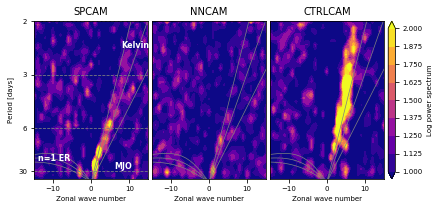

In [412]:
fig, axs = plt.subplots(1, 3, figsize=(pagewidth, 3))
for i, (ax, wk) in enumerate(zip(axs.flat, wks[6:])):
    im = wk_panel(ax, wk, titles[i], True if i == 0 else False, cmap='plasma', 
                  levels=np.linspace(1, 2, 9), extend='both')
    if i > 0: ax.set_ylabel(''); ax.set_yticks([])
plt.subplots_adjust(wspace=0.03, bottom=0.15)
cb = fig.colorbar(im, ax=axs, pad=0.01); cb.set_label('Log power spectrum')

In [162]:
fig.savefig(f'{FIG_DIR}wk.pdf')